## IMPLEMENTACJA

In [249]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [250]:
# activation functions
def sigmoid(x, der=False):
    if der:
        y = sigmoid(x)
        return y * (1 - y)
    else:
        return np.exp(x) / (1 + np.exp(x))

def linear_function (X, W):
    X = np.c_[np.ones(X.shape[0]), X]
    return X @ W

In [330]:
# create NeuralNetwork class
class NeuralNetwork:
    

    # intialize variables in class
    def __init__(self, neurons, activ_function, init = "uniform"):
        
        self.neurons  = neurons # list - how many neurons on each layer
        
        if init == 'uniform':
            self.weights = [np.random.uniform(0,1, (neurons[i-1]+1, neurons[i])) for i in range(1, len(neurons))]
        
        elif init == "Xavier":
            self.weights = [np.random.randn(neurons[i-1]+1, neurons[i])*np.sqrt(1/(neurons[i-1]+1)) for i in range(1, len(neurons))]
  
        elif init == "He":
           self.weights = [np.random.randn(neurons[i-1]+1, neurons[i])*np.sqrt(2/(neurons[i-1]+1+neurons[i])) for i in range(1, len(neurons))]
             
        self.activ_function = activ_function
        self.gradW = [np.zeros_like(e) for e in self.weights]

    def forward(self, X):
        for i in range (len(self.weights)-1):
            X = linear_function(X, self.weights[i])
            X = self.activ_function(X)
        X = linear_function(X, self.weights[i+1])
        return X    
        
    def backpropagate(self, X, y):
        
        self.gradW = [np.zeros_like(e) for e in self.weights]
        layers = []
        layers.append(X)
        for i in range(len(self.weights)):
            layers.append(linear_function(X, self.weights[i]))
            if i == len(self.weights)-1: break
            X = self.activ_function(layers[i+1])
            
        d = layers[len(self.weights)] - y
        
        for i in reversed(range(len(self.weights))):
            self.gradW[i] = np.c_[np.ones(layers[i].shape[0]), self.activ_function(layers[i])].T @ d
            if i != 0:
                d = d @ self.weights[i][1:, :].T * self.activ_function(layers[i], der=True)
        return

In [255]:
def readcsv(path):
    return np.genfromtxt(path, delimiter=',')[1:, 1:]

def scale(X):
    return (X - np.mean(X,0))/np.std(X,0)

def MSE(model, X, y):
    return np.mean((model.forward(X) - y)**2)

In [343]:
def train(model, X, y, n_iter = 10000, alpha= 0.001, method='gradient_descent', beta=0.9):
        
    mse = []
    
    if method=='gradient_descent':
        for i in range(n_iter):
                
            model.backpropagate(X,y)
            for i in range(len(model.weights)):
                model.weights[i] -= alpha*model.gradW[i]
            mse.append(MSE(model,X,y))
                
            
    elif method=='momentum':
        momentum = [np.zeros_like(e) for e in model.weights]
        for i in range(n_iter):                
            model.backpropagate(X,y)
            for j in range(len(model.weights)):
                momentum[j] = beta*momentum[j] + model.gradW[j]
                model.weights[j] -= alpha * momentum[j]
            mse.append(MSE(model,X,y))
        
    elif method=='rms':
        grad_squared = [np.zeros_like(e) for e in model.weights]
        for i in range(n_iter):
            model.backpropagate(X,y)
            grad_squared = np.multiply(beta, grad_squared) + (1 - beta) * np.square(model.gradW)
            for j in range(len(model.weights)):
                model.weights[j] -= alpha * model.gradW[j]/np.sqrt(grad_squared[j])
            mse.append(MSE(model,X,y))
        
    return mse

## TESTY NA ZBIORACH

In [332]:
data1 = readcsv("square-large-training.csv")
data1 = scale(data1)
data1

array([[-1.40997741,  0.48196089],
       [ 0.26974234, -0.84252002],
       [-1.39948318,  0.45588174],
       ...,
       [ 0.01961383, -1.00873208],
       [ 0.3391374 , -0.7738698 ],
       [-1.29863176,  0.21666986]])

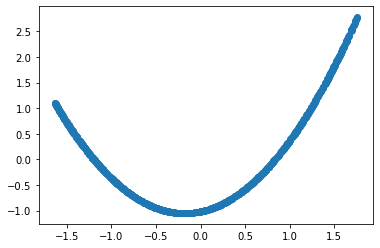

In [333]:
plt.scatter(data1[:,0], data1[:,1])

In [334]:
X = data1[:, 0:1] # inputs
y = data1[:, 1:2] # outputs

In [381]:
compare = []

### Stochastic gradient descent

In [382]:
NN = NeuralNetwork([1, 10, 1], sigmoid, init='Xavier')
mse = train(NN,X,y)
compare.append(mse)
print(mse[-1])

0.03731550925427142


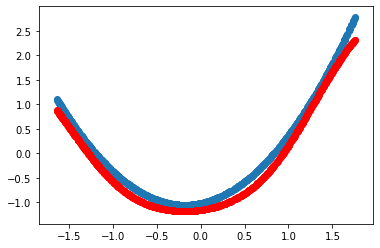

In [383]:
plt.figure()
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data1[:,0], NN.forward(data1[:,0]), c="red")

### Momentum gradient descent

In [384]:
NN = NeuralNetwork([1, 10, 1], sigmoid, init='Xavier')
mse = train(NN,X,y, method='momentum')
compare.append(mse)
print(mse[-1])

0.0001015864127605896


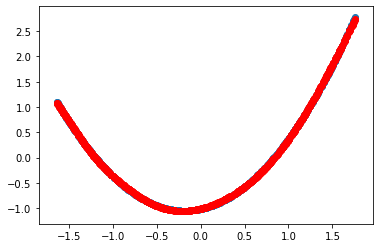

In [385]:
plt.figure()
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data1[:,0], NN.forward(data1[:,0]), c="red")

### RMSprop

In [386]:
NN = NeuralNetwork([1, 10, 1], sigmoid, init='Xavier')
mse = train(NN,X,y,method='rms')
compare.append(mse)
print(mse[-1])

7.333286535574254e-05


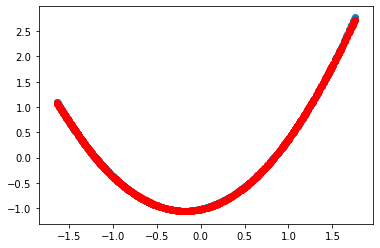

In [387]:
plt.figure()
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data1[:,0], NN.forward(data1[:,0]), c="red")

### Comparison

In [391]:
np.array(compare).T

array([[3.86512336e+00, 5.41286015e+00, 1.03239982e+00],
       [2.72045908e+01, 1.40723439e+01, 1.02899641e+00],
       [1.24630098e+02, 1.67775072e+01, 1.02615799e+00],
       ...,
       [3.73165301e-02, 1.01607589e-04, 7.33547846e-05],
       [3.78943481e-02, 1.01597000e-04, 7.23596904e-05],
       [3.73155093e-02, 1.01586413e-04, 7.33328654e-05]])

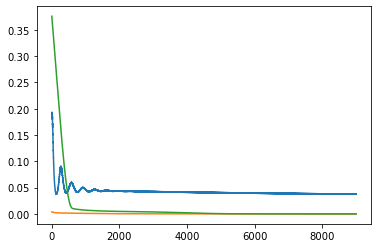

In [409]:
plt.plot(np.array(compare).T[1000:,:])

### KOMENATRZ

Najszybciej zbiega metoda momentum (dla sieci o jednej warstwie ukrytej z 10 neuronami) - przy 10.000 iteracji osiąga najmniejsze MSE. Metoda rms - podobne wyniki
